In [1]:
import torch
from torch import nn, optim
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.temporal import generator_2dspatial_rectangle, generator_2dspatial_segment, generator_temporal
from neurodiffeq.temporal import FirstOrderInitialCondition, BoundaryCondition
from neurodiffeq.temporal import SingleNetworkApproximator2DSpatialSystem, Approximator
from neurodiffeq.temporal import MonitorMinimal
from neurodiffeq.temporal import _solve_2dspatial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

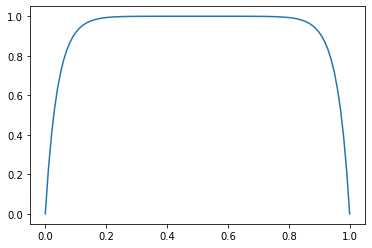

In [2]:
def u_T_approximation(x):
    A = 25. # make A larger, then our network refuse to converge
    return (1-torch.exp(-A*x))*(1-torch.exp(A*(x-1)))
x = torch.linspace(0, 1, 100)
y = u_T_approximation(x)
plt.plot(x, y);

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
class LidDrivenCavityApproximator(Approximator):
    def __init__(self):
        self.u_nn = FCNN(n_input_units=2, n_hidden_units=64, actv=nn.Tanh)
        self.v_nn = FCNN(n_input_units=2, n_hidden_units=64, actv=nn.Tanh)
        self.p_nn = FCNN(n_input_units=2, n_hidden_units=64, actv=nn.Tanh)

    def __call__(self, xx, yy):
        xx = torch.unsqueeze(xx, dim=1)
        yy = torch.unsqueeze(yy, dim=1)
        xy = torch.cat((xx, yy), dim=1)
        uu = torch.squeeze(self.u_nn(xy))
        vv = torch.squeeze(self.v_nn(xy))
        pp = torch.squeeze(self.p_nn(xy))
        
        xx = torch.squeeze(xx, dim=1)
        yy = torch.squeeze(yy, dim=1)
        uu = xx*(1-xx)*yy*(1-yy)*uu + yy*u_T_approximation(xx)
        vv = xx*(1-xx)*yy*(1-yy)*vv
        pp = (1-torch.exp(-xx))*(1-torch.exp(-yy))*pp
        return uu, vv, pp

    def parameters(self):
        return list(self.u_nn.parameters()) + list(self.v_nn.parameters()) + list(self.p_nn.parameters())

    def calculate_loss(self, xx, yy):
        uu = self.__call__(xx, yy)

        equation_mse = sum(
            torch.mean(eq**2)
            for eq in self.pde(*uu, xx, yy)
        )

        return equation_mse

    def calculate_metrics(self, xx, yy, metrics):
        uu = self.__call__(xx, yy)

        return {
            metric_name: metric_func(*uu, xx, yy)
            for metric_name, metric_func in metrics.items()
        }
    
    @staticmethod
    def pde(u, v, p, x, y):
        RE = 100.0
        momentum_x = u*diff(u, x) + v*diff(u, y) + diff(p, x) - 1/RE * (diff(u, x, order=2) + diff(u, y, order=2))
        momentum_y = u*diff(v, x) + v*diff(v, y) + diff(p, y) - 1/RE * (diff(v, x, order=2) + diff(v, y, order=2))
        continuity = diff(u, x) + diff(v, y)
        return momentum_x, momentum_y, continuity

In [5]:
# training set and validation set
train_gen_spatial = generator_2dspatial_rectangle(
    size=(32, 32), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0
)
valid_gen_spatial = generator_2dspatial_rectangle(
    size=(10, 10), x_min=0.0, x_max=1.0, y_min=0.0, y_max=1.0, random=False
)
fcnn_approximator = LidDrivenCavityApproximator()
adam = optim.Adam(fcnn_approximator.parameters(), lr=0.001)

<IPython.core.display.Javascript object>


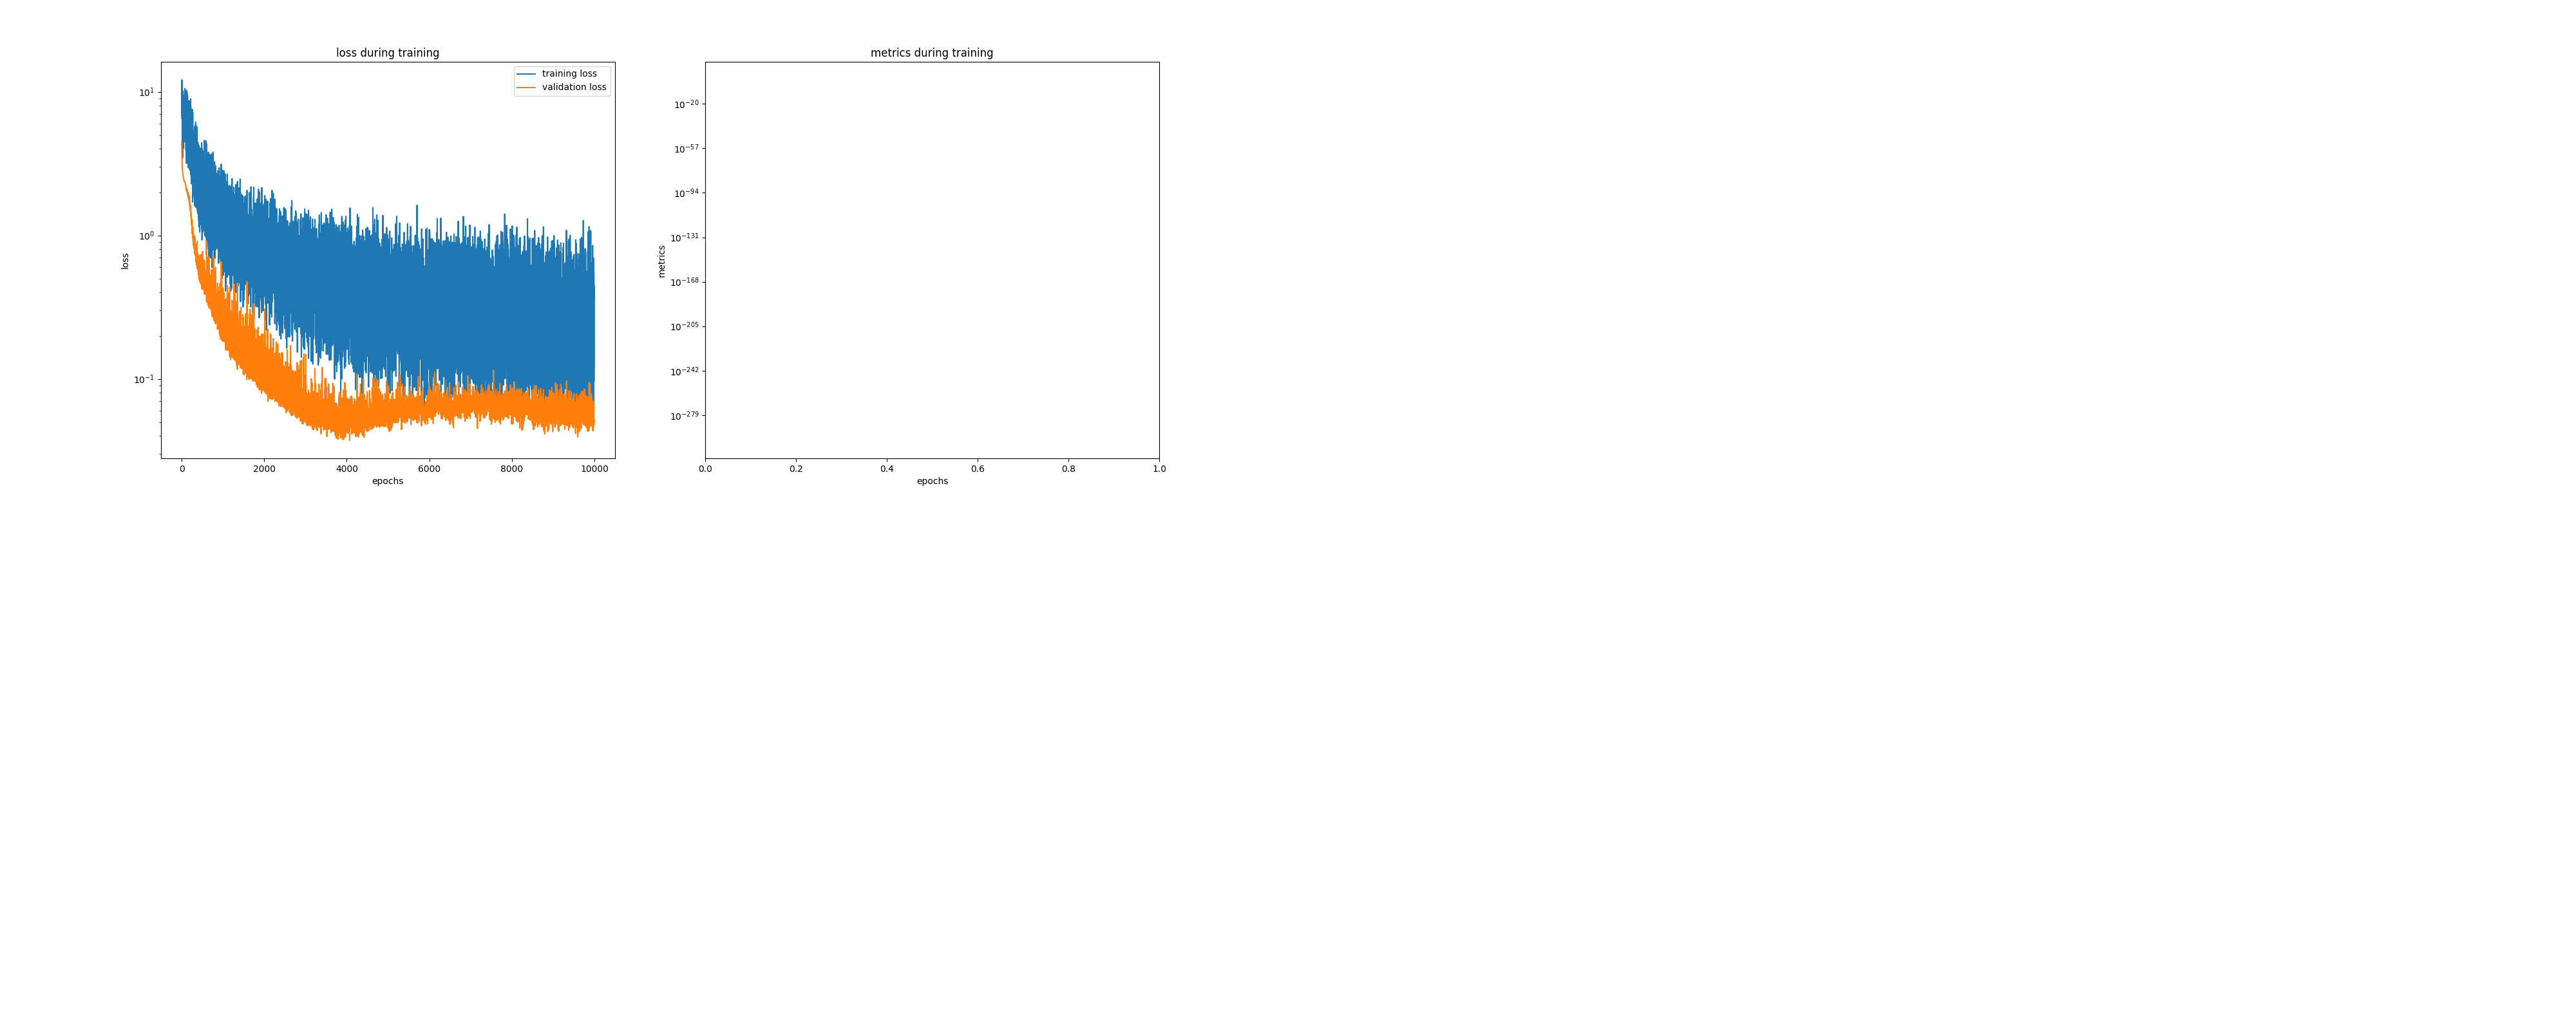

In [6]:
%matplotlib notebook
lid_driven_cavity_solution, _ = _solve_2dspatial(
    train_generator_spatial=train_gen_spatial,
    valid_generator_spatial=valid_gen_spatial,
    approximator=fcnn_approximator,
    optimizer=adam,
    batch_size=256,
    max_epochs=10000,
    shuffle=True,
    metrics={},
    monitor=MonitorMinimal(check_every=10)
)
%matplotlib inline

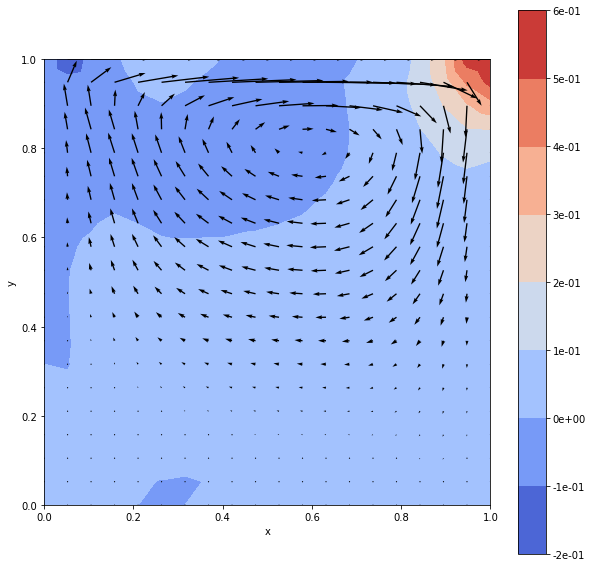

In [12]:
xx, yy = torch.meshgrid(torch.linspace(0,1,20), torch.linspace(0,1,20))
xx = xx.flatten()
yy = yy.flatten()
uu, vv, pp = lid_driven_cavity_solution(xx, yy)

xx = xx.detach().numpy()
yy = yy.detach().numpy()
uu = uu.detach().numpy()
vv = vv.detach().numpy()
pp = pp.detach().numpy()

fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

triang = tri.Triangulation(xx, yy)
contour = ax.tricontourf(triang, pp, cmap='coolwarm')
fig.colorbar(contour, format='%.0e', ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal', adjustable='box')

xx = xx.reshape(20, 20)
yy = yy.reshape(20, 20)
uu = uu.reshape(20, 20)
vv = vv.reshape(20, 20)
ax.quiver(xx, yy, uu, vv, scale=4)

plt.show()